In [64]:
# macro do ipython para rederizar o matplotlib inline
%matplotlib inline

# numpy é uma biblioteca de python que 
# nos permite fazer operações matriciais e vetoriais
# facilmente, e eficientemente (até um certo tamanho)
import numpy as np

import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

import time

### Carregando conjunto de dados

Vamos utilizar o mesmo conjunto de dados do notebook do SVM (aula_01). O conjunto de dados 20 newsgroups disponível no scikit-learn. Esse conjunto de dados possui aproximadamente 18000 newsgroups posts categorizados em 20 tópicos dividos em dois conjuntos: um para treino e outro para teste (em outras palavras, para avaliação de desempenho do modelo). A divisão entre conjunto de treino e teste basedo em mensagens postadas antes e depois uma data específica.


Vamos então carregá-lo e fazer a transformação para espaço vetorial como **bag-of-words** usando o scikit-learn.

In [97]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

train_20ng = fetch_20newsgroups(subset='train', shuffle=False, remove=('headers', 'quotes', 'footers'))
test_20ng = fetch_20newsgroups(subset='test', shuffle=False, remove=('headers', 'quotes', 'footers'))

# transforma dados textuais em uma representação vetorial usando
# bag-of-words
vec = CountVectorizer(stop_words='english', min_df=2)

X_train = vec.fit_transform(train_20ng.data)
y_train = train_20ng.target

X_test = vec.transform(test_20ng.data)
y_test = test_20ng.target

print("N. de Exmplos de Treino: %d; N. de Atributos: %d" % X_train.shape)
print("N. de Exmplos de Teste: %d; N. de Atributos: %d" % X_test.shape)

N. de Exmplos de Treino: 11314; N. de Atributos: 39115
N. de Exmplos de Teste: 7532; N. de Atributos: 39115


## Holdout

Vamos utilizar a técnica holdout para selecionar o parâmetro C do svm, profundidae máxima de um àrvore de Decisão, e o hiperparâmetro da regressão logística. Lembre-se que no holdout nós dividimos o conjunto de dados em 3 conjuntos distintos, um para treino (avaliação de performance), validação (seleção do modelo/parâmetros) e treino.

O scikit já divide o conjunto de dados em treino e teste, como pode ser notado acima. Desse modo vamos apenas dividir o conjunto de treino em dois (validação e treino).

In [98]:
from sklearn.model_selection import train_test_split
X_train_aux, X_valid, y_train_aux, y_valid = train_test_split(X_train, y_train, test_size=0.4, random_state=0)

Quais valores de C escolher? Então, testar todos os valores de C pode ser inviável. Desse modo nós podemos chutar alguns valores que façam sentidos. Por exemplos, valores pequenos, médio e grandes, e assim testá-los.

In [99]:
Cs = 2. ** np.arange(-12, -2, 0.25)
Cs

array([ 0.00024414,  0.00029033,  0.00034527,  0.00041059,  0.00048828,
        0.00058067,  0.00069053,  0.00082119,  0.00097656,  0.00116134,
        0.00138107,  0.00164238,  0.00195312,  0.00232267,  0.00276214,
        0.00328475,  0.00390625,  0.00464534,  0.00552427,  0.0065695 ,
        0.0078125 ,  0.00929068,  0.01104854,  0.01313901,  0.015625  ,
        0.01858136,  0.02209709,  0.02627801,  0.03125   ,  0.03716272,
        0.04419417,  0.05255603,  0.0625    ,  0.07432544,  0.08838835,
        0.10511205,  0.125     ,  0.14865089,  0.1767767 ,  0.2102241 ])

Desse modo, para cada valor de C vamos aprender um modelo usando nosso ```X_train_aux``` e então avaliá-lo usando alguma métrica e o valores preditos no conjunto de ```X_valid```.

In [100]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.base import clone

svm = LinearSVC(random_state=0)

def holdout(clf, param_valores):
    best_score = 0
    best_param = 0
    for param, valores in param_valores.items():
        resultados = np.zeros((valores.shape[0], 4))
        
        # Para cada valor dos hiperparâmetro
        # nós criamos um modelo diferente com 
        # conjunto de treino auxiliar. 
        # Após termos o modelo com tal parâmetro,
        # fazemos a predição no conjunto de validação
        # e utilizamos alguma métrica para
        # obtermos um score para aquele método, e então,
        # escolher o paramêtro (ou conjunto de parâmetros)
        # gerou o modelo com maior score.
        for i, val in enumerate(valores):
            # clonando classificador e atribuindo o parametro
            classificador = clone(clf)
            classificador.set_params(**{param: val})
            
            # aprendendo um modelo baseado no conjunto de treino auxiliar
            classificador.fit(X_train_aux, y_train_aux)
            
            # predição baseada no conjunto de validação
            y_pred = classificador.predict(X_valid)

            # score para avaliação do modelo.
            score = f1_score(y_valid, y_pred, average="macro")

            # melhor parâmetro de acordo com score
            if best_score < score:
                best_score = score
                best_param = val

            # score no conjunto de validação, treino e teste para cada um dos valores do parâmetro
            # vamos utilizar isso para traçar a curva do compromisso viés e variância
            resultados[i, 0] = val
            resultados[i, 1] = 1 - score
            resultados[i, 2] = 1 - f1_score(y_train_aux, classificador.predict(X_train_aux), average="macro")
            resultados[i, 3] = 1 - f1_score(y_test, classificador.predict(X_test), average="macro")
        
    
    print("Melhor F1 : %f; Melhor %s : %f" % (best_score, param, best_param))
    return resultados, best_score, best_param

resultados, best_score, best_param = holdout(svm, {'C': Cs})           

Melhor F1 : 0.707446; Melhor C : 0.011049


In [102]:
svm.set_params(**{'C': best_param})
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

score = f1_score(y_test, y_pred, average="micro")
print("F1 no Teste: %f" % (score))

F1 no Teste: 0.656798


In [103]:
svm.set_params(**{'C': best_param})
svm.fit(X_train_aux, y_train_aux)
y_pred = svm.predict(X_valid)

score = f1_score(y_valid, y_pred, average="micro")
print("F1 no Teste: %f" % (score))

F1 no Teste: 0.714980


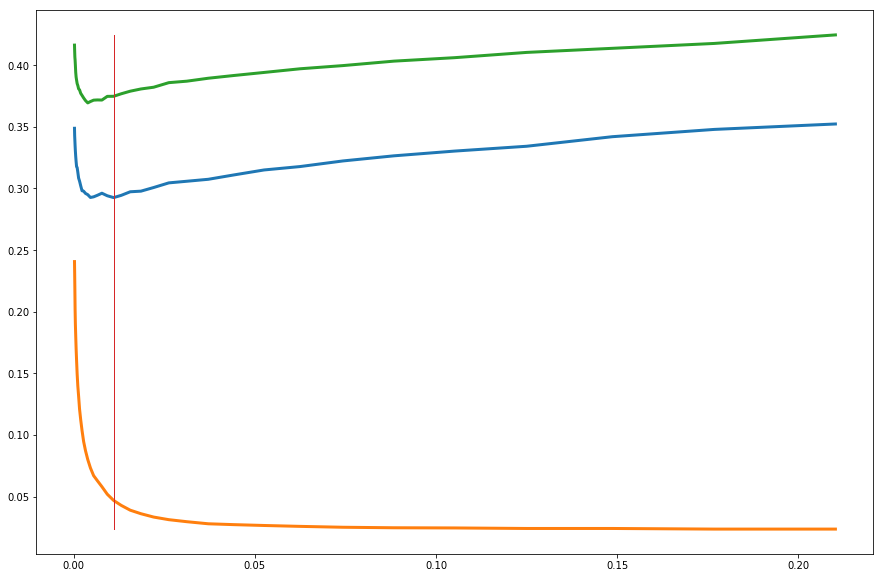

In [101]:
def plot_bias_variance_tradeoff(resultados, best_param = None):
    for j in range(resultados.shape[1] - 1):
        plt.plot(resultados[:, 0], resultados[:, j + 1],
                 linewidth=3)
    if best_param:
        plt.plot([best_param, best_param], [resultados[:,1:].min(), resultados[:,1:].max()],
                 linewidth=1)

plot_bias_variance_tradeoff(resultados, best_param)

In [9]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0, max_features=1.0)

profundidades = np.array([1, 5, 8, 25] + list(range(50, 130, 10)) + [200, 250, 300, 350, 500, 800, 1000])

resultados, best_score, best_param = holdout(dt, {'max_depth': profundidades})

/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Melhor F1 : 0.471080; Melhor max_depth : 200.000000


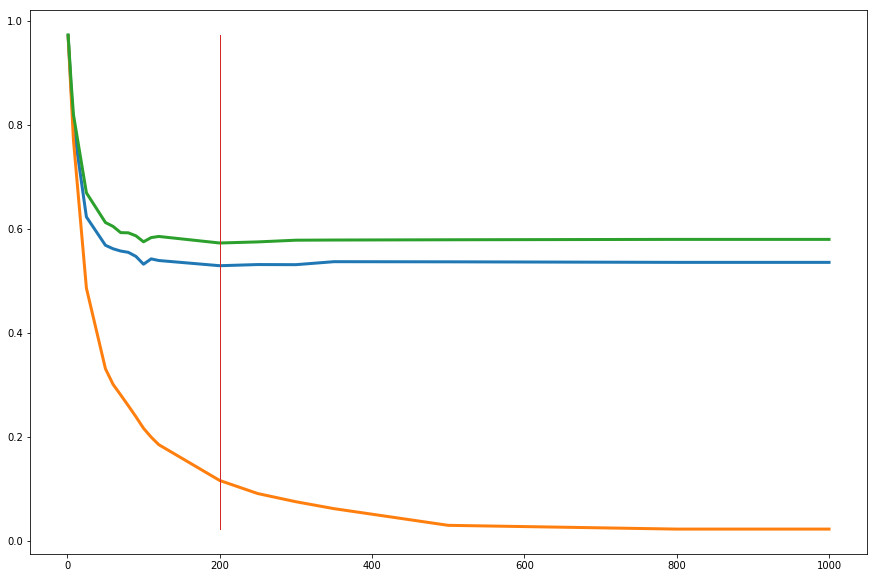

In [10]:
plot_bias_variance_tradeoff(resultados, best_param)

Melhor F1 : 0.701559; Melhor C : 0.297302


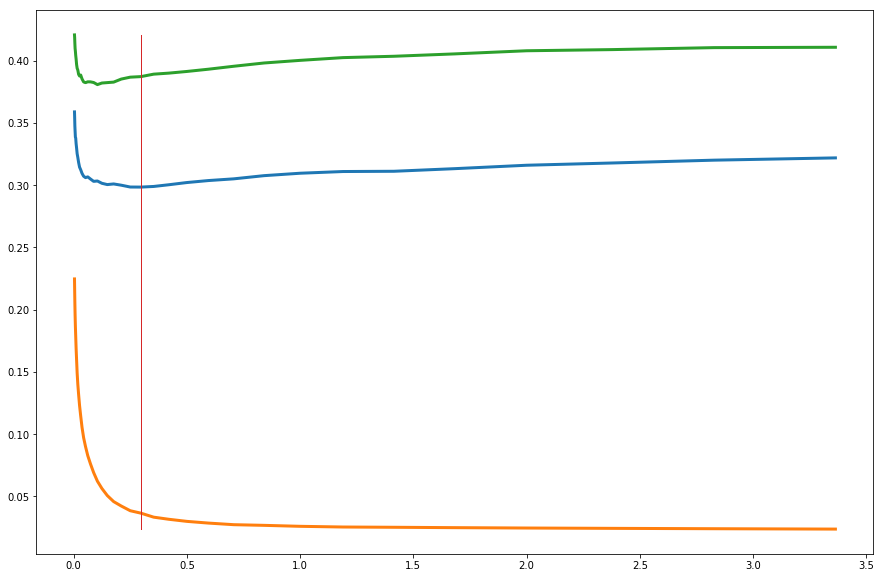

In [11]:
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression(random_state=0, dual=True, n_jobs=-1)

Cs = 2. ** np.arange(-8, 2, 0.25)

resultados, best_score, best_param = holdout(lreg, {'C': Cs})
plot_bias_variance_tradeoff(resultados, best_param)

In [32]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

alphas = np.arange(0, 1, 0.1)

resultados, best_score, best_param = holdout(nb, {'alpha': alphas[::-1]})

Melhor F1 : 0.680452; Melhor alpha : 0.300000


/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


## Leave-one-out e Validação Cruzada

In [60]:
from sklearn.model_selection import LeaveOneOut

inicio = time.time()

loo = LeaveOneOut()
y_pred = np.zeros((X_train.shape[0]))
for index_train, index_valid in loo.split(X_train):
    X_train_aux, X_valid = X_train[index_train], X_train[index_valid]
    y_train_aux, y_valid = y_train[index_train], y_train[index_valid]
    
    nb.fit(X_train_aux, y_train_aux)
    y_pred[index_valid] = nb.predict(X_valid)
    
fim = time.time()
print("Melhor F1 : %f; Tempo : %.2f" % (f1_score(y_train, y_pred, average = "macro"), fim - inicio))

Melhor F1 : 0.682743; Tempo : 446.94


In [63]:
print("Melhor F1 : %f;" % (f1_score(y_test, nb.predict(X_test), average = "macro")))

Melhor F1 : 0.617725;


Leave-one-out é inviável quando temos muitos dados. Eu só estou utilizando para estimar o erro em teste, mesmo assim demora um tempão. Note que eu estou usando o naïve bayes para isso e ele é um dos métodos com processo de aprendizado mais rápido, portanto, é possível enxergar que esse método fosse utilizado para escolher o valor do hiperparâmetro serio praticamente impossível obtê-lo em um tempo aceitável.

O leave-one-out é um caso especial da validação cruzada (cross-validation), quando temos N conjuntos disjuntos. Na estratégia da validação cruzada, nós divitimos o conjunto de treino em K conjuntos de tamanho similar e disjuntos, chamados de ***Folds*** (**K-Fold Cross-Validation**). Modelo é aprendido utilizando K - 1 *folds*, o *fold* deixado de fora do treino é utilizado para predição e avaliação do modelo. Esse processo é repetido K vezes para que cada *fold* seja usado para predição ao menos uma vez. Avaliação final do modelo é dado pela média das avaliações em cada *fold*. 

No leave-one-out, nós temos que K = N (quantidade de exemplos no conjunto de treino). 

T. Hastie, R. Tibshirani, J. Friedman, The Elements of Statistical Learning, Springer 2009

In [107]:
from sklearn.model_selection import validation_curve, KFold, ShuffleKFo

ordered = np.argsort(y_train)

Cs = 2. ** np.arange(-12, -2, 0.5)
cv = KFold(n_splits = 5)
train_scores, valid_scores = validation_curve(svm, X_train[ordered], y_train[ordered], 'C', Cs, cv=cv, n_jobs=-1, scoring='f1_macro')

/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/

Melhor F1 : 0.034786; Melhor C : 0.044194


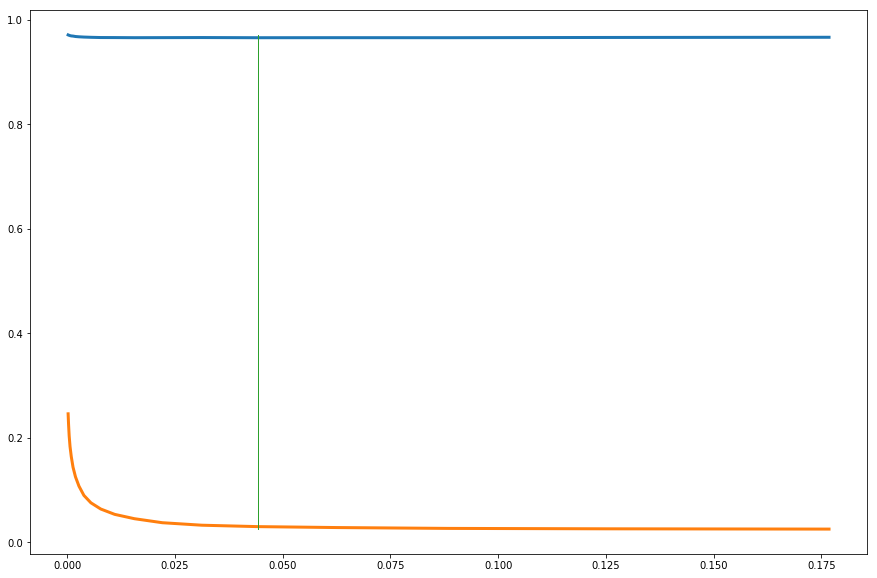

In [108]:
mean_valid_score = valid_scores.mean(1)
mean_train_score = train_scores.mean(1)

best_param_index = np.argmax(mean_valid_score)

print("Melhor F1 : %f; Melhor C : %f" % (mean_valid_score[best_param_index], Cs[best_param_index]))

resultados = np.vstack((Cs, 1 - mean_valid_score, 1 - mean_train_score)).T
plot_bias_variance_tradeoff(resultados, Cs[best_param_index])

Melhor F1 : 0.718348; Melhor C : 0.007812


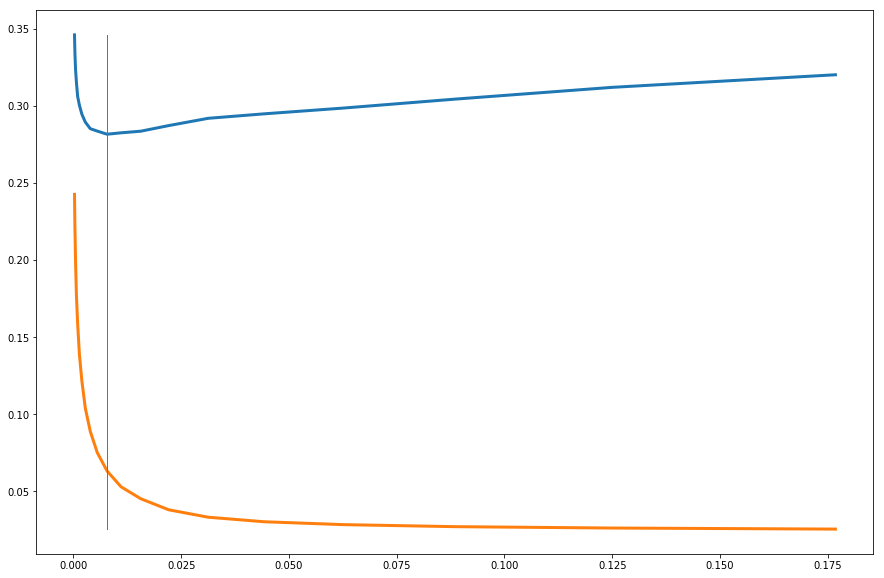

In [112]:
# ordered = np.argsort(y_train)
Cs = 2. ** np.arange(-12, -2, 0.5)
cv = KFold(n_splits = 5)
train_scores, valid_scores = validation_curve(svm, X_train, y_train, 'C', Cs, cv=cv, n_jobs=-1, scoring='f1_macro')

mean_valid_score = valid_scores.mean(1)
mean_train_score = train_scores.mean(1)

best_param_index = np.argmax(mean_valid_score)

print("Melhor F1 : %f; Melhor C : %f" % (mean_valid_score[best_param_index], Cs[best_param_index]))

resultados = np.vstack((Cs, 1 - mean_valid_score, 1 - mean_train_score)).T
plot_bias_variance_tradeoff(resultados, Cs[best_param_index])

Melhor F1 : 0.724111; Melhor C : 0.011049


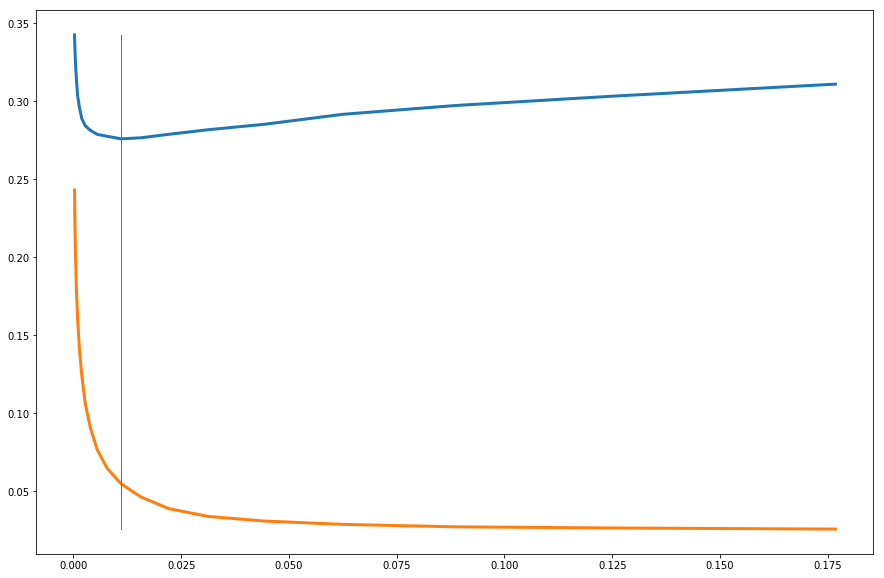

In [96]:
Cs = 2. ** np.arange(-12, -2, 0.5)
cv = KFold(n_splits = 10)
train_scores, valid_scores = validation_curve(svm, X_train, y_train, 'C', Cs, cv=cv, n_jobs=-1, scoring='f1_macro')

mean_valid_score = valid_scores.mean(1)
mean_train_score = train_scores.mean(1)

best_param_index = np.argmax(mean_valid_score)

print("Melhor F1 : %f; Melhor C : %f" % (mean_valid_score[best_param_index], Cs[best_param_index]))

resultados = np.vstack((Cs, 1 - mean_valid_score, 1 - mean_train_score)).T
plot_bias_variance_tradeoff(resultados, Cs[best_param_index])

### Calibrando mais de um hiperparâmetro

E quando o modelo possui mais de um hiperparâmetro, como fazer a calibragem?

- Fazer a calibragem individual de cada um deles, sempre escolhendo o melhor valor para cada hiperparâmetro individual.
  
  - Não leva em consideração que os hiperparâmtros podem afetar uns aos outros
  - Menos custo
  
- Usar um tática força bruta, e tentar todas as combinações de hiperparâmetros. Essa técnica é conhecida como GridSearch
  - Pode ser muito custosa computacionalmente

- Fazer uma exploração aleatória em busca dos melhores valores
  - Computanionalmente melhor que GridSearch, porém pode ser resultar em o modelo pior que usando a técnica do GridSearch.
    
  
Scikit-learn nos oferece formas simples tanto de fazer um gridsearch quanto fazer uma busca aleatória, respectivamente com os modulos, **GridSearchCV** e **RandomizedSearchCV**.

In [113]:
svm

LinearSVC(C=0.011048543456039806, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=0,
     tol=0.0001, verbose=0)

Além do hiperparâmetro C, a implementação do SVM linear disponibilizada pelo Scikit-learn tem outros parâmetros que influenciam o aprendizado do modelo, e portanto, sua predição final. Dessa forma, podemos calibrá-los juntamente com C.

Vamos então fazer isso utilizando o  **GridSearchCV** e **RandomizedSearchCV** do scikit.

In [135]:
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV

param_grid = {
    'C': 2. ** np.arange(-12, -2, 0.5),
    'class_weight': [None, 'balanced'],
             }
grid = GridSearchCV(svm, param_grid, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=10)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=0.000244140625, class_weight=None .............................
[CV] C=0.000244140625, class_weight=None .............................
[CV] C=0.000244140625, class_weight=None .............................
[CV] C=0.000244140625, class_weight=None .............................
[CV] C=0.000244140625, class_weight=None .............................
[CV] C=0.000244140625, class_weight=balanced .........................
[CV] C=0.000244140625, class_weight=balanced .........................
[CV] C=0.000244140625, class_weight=balanced .........................
[CV]  C=0.000244140625, class_weight=None, score=0.656710, total=   1.9s
[CV] C=0.000244140625, class_weight=balanced .........................
[CV]  C=0.000244140625, class_weight=balanced, score=0.657889, total=   1.9s
[CV] C=0.000244140625, class_weight=balanced .........................
[CV]  C=0.000244140625, class_weight=None, score=0.653323, total=   2.1s
[CV] 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s


[CV] C=0.000345266983001, class_weight=None ..........................
[CV]  C=0.000244140625, class_weight=None, score=0.653290, total=   2.2s
[CV] C=0.000345266983001, class_weight=None ..........................
[CV]  C=0.000244140625, class_weight=None, score=0.643926, total=   2.3s
[CV] C=0.000345266983001, class_weight=None ..........................
[CV]  C=0.000244140625, class_weight=balanced, score=0.666381, total=   2.6s
[CV] C=0.000345266983001, class_weight=None ..........................
[CV]  C=0.000244140625, class_weight=None, score=0.662162, total=   2.9s
[CV] C=0.000345266983001, class_weight=balanced ......................
[CV]  C=0.000244140625, class_weight=balanced, score=0.662644, total=   1.9s
[CV] C=0.000345266983001, class_weight=balanced ......................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.0s


[CV]  C=0.000345266983001, class_weight=None, score=0.659423, total=   1.8s
[CV] C=0.000345266983001, class_weight=balanced ......................
[CV]  C=0.000345266983001, class_weight=None, score=0.675587, total=   2.0s
[CV] C=0.000345266983001, class_weight=balanced ......................
[CV]  C=0.000345266983001, class_weight=None, score=0.669306, total=   2.0s
[CV]  C=0.000244140625, class_weight=balanced, score=0.656523, total=   2.4s
[CV] C=0.000345266983001, class_weight=balanced ......................
[CV]  C=0.000345266983001, class_weight=None, score=0.666787, total=   2.1s
[CV] C=0.00048828125, class_weight=None ..............................
[CV] C=0.00048828125, class_weight=None ..............................
[CV]  C=0.000345266983001, class_weight=balanced, score=0.678362, total=   1.9s
[CV] C=0.00048828125, class_weight=None ..............................
[CV]  C=0.000345266983001, class_weight=None, score=0.658176, total=   2.5s
[CV] C=0.00048828125, class_weight=No

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s


[CV]  C=0.000345266983001, class_weight=balanced, score=0.670839, total=   2.2s
[CV]  C=0.000345266983001, class_weight=balanced, score=0.670727, total=   2.0s
[CV] C=0.00048828125, class_weight=None ..............................
[CV] C=0.00048828125, class_weight=balanced ..........................
[CV]  C=0.000345266983001, class_weight=balanced, score=0.675161, total=   2.1s
[CV] C=0.00048828125, class_weight=balanced ..........................
[CV]  C=0.000345266983001, class_weight=balanced, score=0.663598, total=   2.2s
[CV] C=0.00048828125, class_weight=balanced ..........................
[CV]  C=0.00048828125, class_weight=None, score=0.673091, total=   2.1s
[CV] C=0.00048828125, class_weight=balanced ..........................
[CV]  C=0.00048828125, class_weight=None, score=0.678514, total=   3.4s
[CV] C=0.00048828125, class_weight=balanced ..........................
[CV]  C=0.00048828125, class_weight=None, score=0.678755, total=   2.7s
[CV] C=0.000690533966002, class_weight

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.3s


[CV]  C=0.00048828125, class_weight=balanced, score=0.681343, total=   3.4s
[CV] C=0.000690533966002, class_weight=None ..........................
[CV]  C=0.00048828125, class_weight=None, score=0.667023, total=   3.9s
[CV] C=0.000690533966002, class_weight=None ..........................
[CV]  C=0.00048828125, class_weight=balanced, score=0.680456, total=   3.2s
[CV] C=0.000690533966002, class_weight=balanced ......................
[CV]  C=0.00048828125, class_weight=None, score=0.683900, total=   6.0s
[CV] C=0.000690533966002, class_weight=balanced ......................
[CV]  C=0.00048828125, class_weight=balanced, score=0.671186, total=   3.2s
[CV] C=0.000690533966002, class_weight=balanced ......................
[CV]  C=0.000690533966002, class_weight=None, score=0.682246, total=   2.0s
[CV] C=0.000690533966002, class_weight=balanced ......................
[CV]  C=0.000690533966002, class_weight=None, score=0.695919, total=   3.2s
[CV] C=0.000690533966002, class_weight=balanced ..

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s


[CV]  C=0.000690533966002, class_weight=balanced, score=0.686249, total=   2.4s
[CV] C=0.0009765625, class_weight=None ...............................
[CV]  C=0.000690533966002, class_weight=balanced, score=0.696063, total=   2.2s
[CV] C=0.0009765625, class_weight=None ...............................
[CV]  C=0.000690533966002, class_weight=balanced, score=0.687120, total=   2.4s
[CV] C=0.0009765625, class_weight=None ...............................
[CV]  C=0.000690533966002, class_weight=balanced, score=0.700357, total=   3.3s
[CV] C=0.0009765625, class_weight=balanced ...........................
[CV]  C=0.000690533966002, class_weight=balanced, score=0.677483, total=   2.7s
[CV] C=0.0009765625, class_weight=balanced ...........................
[CV]  C=0.0009765625, class_weight=None, score=0.698602, total=   3.3s
[CV] C=0.0009765625, class_weight=balanced ...........................
[CV]  C=0.000690533966002, class_weight=None, score=0.686025, total=   5.8s
[CV] C=0.0009765625, class_

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   18.0s


[CV]  C=0.001381067932, class_weight=None, score=0.711630, total=   2.4s
[CV] C=0.001381067932, class_weight=None .............................
[CV]  C=0.0009765625, class_weight=balanced, score=0.686572, total=   2.9s
[CV] C=0.001381067932, class_weight=None .............................
[CV]  C=0.0009765625, class_weight=balanced, score=0.711024, total=   5.1s
[CV] C=0.001381067932, class_weight=balanced .........................
[CV]  C=0.0009765625, class_weight=None, score=0.694996, total=   5.5s
[CV] C=0.001381067932, class_weight=balanced .........................
[CV]  C=0.001381067932, class_weight=None, score=0.704832, total=   2.2s
[CV] C=0.001381067932, class_weight=balanced .........................
[CV]  C=0.0009765625, class_weight=balanced, score=0.698243, total=   3.9s
[CV] C=0.001381067932, class_weight=balanced .........................
[CV]  C=0.001381067932, class_weight=balanced, score=0.706915, total=   2.2s
[CV] C=0.001381067932, class_weight=balanced ..........

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   22.1s


[CV]  C=0.001381067932, class_weight=balanced, score=0.705826, total=   3.2s
[CV] C=0.001953125, class_weight=None ................................
[CV]  C=0.001381067932, class_weight=None, score=0.697431, total=   5.0s
[CV] C=0.001953125, class_weight=balanced ............................
[CV] . C=0.001953125, class_weight=None, score=0.715905, total=   2.5s
[CV] C=0.001953125, class_weight=balanced ............................
[CV] . C=0.001953125, class_weight=None, score=0.706239, total=   2.8s
[CV] C=0.001953125, class_weight=balanced ............................
[CV]  C=0.001381067932, class_weight=balanced, score=0.701314, total=   5.3s
[CV] C=0.001953125, class_weight=balanced ............................
[CV] . C=0.001953125, class_weight=None, score=0.689381, total=   3.6s
[CV] C=0.001953125, class_weight=balanced ............................
[CV]  C=0.001953125, class_weight=balanced, score=0.725788, total=   2.6s
[CV] C=0.00276213586401, class_weight=None .................

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   29.7s


[CV] C=0.00276213586401, class_weight=balanced .......................
[CV]  C=0.00276213586401, class_weight=None, score=0.709813, total=   3.7s
[CV] C=0.00276213586401, class_weight=balanced .......................
[CV]  C=0.001953125, class_weight=balanced, score=0.703316, total=   5.1s
[CV] C=0.00276213586401, class_weight=balanced .......................
[CV]  C=0.00276213586401, class_weight=None, score=0.716058, total=   3.6s
[CV] C=0.00390625, class_weight=None .................................
[CV]  C=0.00276213586401, class_weight=None, score=0.707365, total=   3.6s
[CV] C=0.00390625, class_weight=None .................................
[CV]  C=0.00276213586401, class_weight=None, score=0.697210, total=   3.8s
[CV] C=0.00390625, class_weight=None .................................
[CV]  C=0.00276213586401, class_weight=balanced, score=0.729153, total=   2.6s
[CV] C=0.00390625, class_weight=None .................................
[CV]  C=0.00276213586401, class_weight=balanced, s

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   35.1s


[CV] C=0.00552427172802, class_weight=None ...........................
[CV] .. C=0.00390625, class_weight=None, score=0.720932, total=   4.1s
[CV] C=0.00552427172802, class_weight=None ...........................
[CV]  C=0.00390625, class_weight=balanced, score=0.734351, total=   3.0s
[CV] C=0.00552427172802, class_weight=None ...........................
[CV]  C=0.00390625, class_weight=balanced, score=0.708148, total=   2.8s
[CV] C=0.00552427172802, class_weight=None ...........................
[CV]  C=0.00390625, class_weight=balanced, score=0.718963, total=   3.5s
[CV] C=0.00552427172802, class_weight=None ...........................
[CV] .. C=0.00390625, class_weight=None, score=0.699714, total=   5.3s
[CV] C=0.00552427172802, class_weight=balanced .......................
[CV]  C=0.00552427172802, class_weight=None, score=0.724941, total=   3.3s
[CV] C=0.00552427172802, class_weight=balanced .......................
[CV]  C=0.00552427172802, class_weight=None, score=0.717436, total=

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   42.2s


[CV]  C=0.00552427172802, class_weight=balanced, score=0.726544, total=   3.6s
[CV] C=0.0078125, class_weight=balanced ..............................
[CV]  C=0.00552427172802, class_weight=None, score=0.699008, total=   5.4s
[CV] C=0.0078125, class_weight=balanced ..............................
[CV] ... C=0.0078125, class_weight=None, score=0.727641, total=   3.5s
[CV] C=0.0078125, class_weight=balanced ..............................
[CV] ... C=0.0078125, class_weight=None, score=0.717752, total=   3.5s
[CV] C=0.0078125, class_weight=balanced ..............................
[CV] ... C=0.0078125, class_weight=None, score=0.717986, total=   2.9s
[CV] C=0.0078125, class_weight=balanced ..............................
[CV] ... C=0.0078125, class_weight=None, score=0.727652, total=   3.9s
[CV] C=0.011048543456, class_weight=None .............................
[CV]  C=0.0078125, class_weight=balanced, score=0.727570, total=   3.0s
[CV] C=0.011048543456, class_weight=None .......................

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   50.3s


[CV]  C=0.011048543456, class_weight=None, score=0.730328, total=   4.6s
[CV] C=0.015625, class_weight=None ...................................
[CV]  C=0.011048543456, class_weight=None, score=0.700100, total=   4.0s
[CV] C=0.015625, class_weight=None ...................................
[CV]  C=0.011048543456, class_weight=balanced, score=0.723787, total=   3.6s
[CV] C=0.015625, class_weight=None ...................................
[CV]  C=0.011048543456, class_weight=balanced, score=0.718142, total=   3.0s
[CV] C=0.015625, class_weight=None ...................................
[CV]  C=0.011048543456, class_weight=balanced, score=0.729153, total=   4.2s
[CV] C=0.015625, class_weight=balanced ...............................
[CV]  C=0.011048543456, class_weight=balanced, score=0.714990, total=   4.9s
[CV] C=0.015625, class_weight=balanced ...............................
[CV]  C=0.011048543456, class_weight=balanced, score=0.705923, total=   4.9s
[CV] C=0.015625, class_weight=balanced ....

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.0min


[CV]  C=0.015625, class_weight=balanced, score=0.708420, total=   5.1s
[CV] C=0.0220970869121, class_weight=balanced ........................
[CV]  C=0.0220970869121, class_weight=None, score=0.719823, total=   4.9s
[CV] C=0.0220970869121, class_weight=balanced ........................
[CV]  C=0.0220970869121, class_weight=None, score=0.722537, total=   5.0s
[CV] C=0.03125, class_weight=None ....................................
[CV]  C=0.0220970869121, class_weight=None, score=0.710062, total=   4.3s
[CV] C=0.03125, class_weight=None ....................................
[CV]  C=0.0220970869121, class_weight=None, score=0.703011, total=   4.7s
[CV] C=0.03125, class_weight=None ....................................
[CV]  C=0.0220970869121, class_weight=balanced, score=0.721207, total=   5.0s
[CV] C=0.03125, class_weight=None ....................................
[CV]  C=0.0220970869121, class_weight=balanced, score=0.709106, total=   4.2s
[CV] C=0.03125, class_weight=None .................

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min


[CV] . C=0.03125, class_weight=balanced, score=0.714638, total=   5.5s
[CV] C=0.0441941738242, class_weight=None ............................
[CV] . C=0.03125, class_weight=balanced, score=0.706331, total=   4.4s
[CV] C=0.0441941738242, class_weight=balanced ........................
[CV] . C=0.03125, class_weight=balanced, score=0.716986, total=   6.1s
[CV] C=0.0441941738242, class_weight=balanced ........................
[CV] . C=0.03125, class_weight=balanced, score=0.703334, total=   6.1s
[CV] C=0.0441941738242, class_weight=balanced ........................
[CV]  C=0.0441941738242, class_weight=None, score=0.694920, total=   4.6s
[CV] C=0.0441941738242, class_weight=balanced ........................
[CV]  C=0.0441941738242, class_weight=None, score=0.707248, total=   3.8s
[CV] C=0.0441941738242, class_weight=balanced ........................
[CV]  C=0.0441941738242, class_weight=None, score=0.716804, total=   5.2s
[CV] C=0.0625, class_weight=None ...................................

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.4min


[CV] .. C=0.0625, class_weight=balanced, score=0.691571, total=   5.4s
[CV] C=0.0883883476483, class_weight=None ............................
[CV] .. C=0.0625, class_weight=balanced, score=0.704063, total=   3.9s
[CV] C=0.0883883476483, class_weight=None ............................
[CV] .. C=0.0625, class_weight=balanced, score=0.713827, total=   5.9s
[CV] C=0.0883883476483, class_weight=balanced ........................
[CV] .. C=0.0625, class_weight=balanced, score=0.704425, total=   8.3s
[CV] C=0.0883883476483, class_weight=balanced ........................
[CV] .. C=0.0625, class_weight=balanced, score=0.690606, total=   5.9s
[CV] C=0.0883883476483, class_weight=balanced ........................
[CV]  C=0.0883883476483, class_weight=None, score=0.687248, total=   6.1s
[CV] C=0.0883883476483, class_weight=balanced ........................
[CV]  C=0.0883883476483, class_weight=None, score=0.698756, total=   4.0s
[CV] C=0.0883883476483, class_weight=balanced ........................


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min


[CV] ....... C=0.125, class_weight=None, score=0.679487, total=   7.4s
[CV] C=0.176776695297, class_weight=None .............................
[CV] ... C=0.125, class_weight=balanced, score=0.675154, total=   7.3s
[CV] C=0.176776695297, class_weight=None .............................
[CV] ... C=0.125, class_weight=balanced, score=0.689652, total=   4.4s
[CV] C=0.176776695297, class_weight=None .............................
[CV] ... C=0.125, class_weight=balanced, score=0.696894, total=   7.5s
[CV] C=0.176776695297, class_weight=balanced .........................
[CV] ... C=0.125, class_weight=balanced, score=0.689441, total=   9.3s
[CV] C=0.176776695297, class_weight=balanced .........................
[CV] ... C=0.125, class_weight=balanced, score=0.680307, total=   7.1s
[CV] C=0.176776695297, class_weight=balanced .........................
[CV]  C=0.176776695297, class_weight=None, score=0.669887, total=   8.2s
[CV] C=0.176776695297, class_weight=balanced .........................
[CV]

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.9min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LinearSVC(C=0.011048543456039806, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=0,
     tol=0.0001, verbose=0),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([ 0.00024,  0.00035,  0.00049,  0.00069,  0.00098,  0.00138,
        0.00195,  0.00276,  0.00391,  0.00552,  0.00781,  0.01105,
        0.01562,  0.0221 ,  0.03125,  0.04419,  0.0625 ,  0.08839,
        0.125  ,  0.17678]), 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=10)

In [136]:
print("Melhores parâmetros: %s; Melhor F1: %f" % (grid.best_params_, grid.best_score_))
print("Teste F1: %f" % (f1_score(y_test, grid.predict(X_test), average='macro')))

Melhores parâmetros: {'C': 0.0078125, 'class_weight': 'balanced'}; Melhor F1: 0.720498
Teste F1: 0.648014


In [137]:
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV

param_grid = {
    'C': 2. ** np.arange(-12, -2, 0.5),
    'class_weight': [None, 'balanced'],
             }
rand = RandomizedSearchCV(svm, param_grid, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=10, random_state=0)

rand.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=0.011048543456, class_weight=None .............................
[CV] C=0.011048543456, class_weight=None .............................
[CV] C=0.011048543456, class_weight=None .............................
[CV] C=0.011048543456, class_weight=None .............................
[CV] C=0.011048543456, class_weight=None .............................
[CV] C=0.0078125, class_weight=None ..................................
[CV] C=0.0078125, class_weight=None ..................................
[CV] C=0.0078125, class_weight=None ..................................
[CV]  C=0.011048543456, class_weight=None, score=0.719700, total=   3.2s
[CV] C=0.0078125, class_weight=None ..................................
[CV] ... C=0.0078125, class_weight=None, score=0.717752, total=   3.2s
[CV] C=0.0078125, class_weight=None ..................................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s


[CV]  C=0.011048543456, class_weight=None, score=0.723595, total=   3.9s
[CV] ... C=0.0078125, class_weight=None, score=0.727652, total=   3.8s
[CV] C=0.015625, class_weight=balanced ...............................
[CV] C=0.015625, class_weight=balanced ...............................
[CV] ... C=0.0078125, class_weight=None, score=0.727641, total=   3.9s
[CV] C=0.015625, class_weight=balanced ...............................
[CV]  C=0.011048543456, class_weight=None, score=0.700100, total=   4.3s
[CV] C=0.015625, class_weight=balanced ...............................
[CV]  C=0.011048543456, class_weight=None, score=0.730328, total=   4.6s
[CV] C=0.015625, class_weight=balanced ...............................
[CV]  C=0.011048543456, class_weight=None, score=0.713440, total=   5.0s
[CV] C=0.00048828125, class_weight=None ..............................
[CV] ... C=0.0078125, class_weight=None, score=0.717986, total=   3.3s
[CV] C=0.00048828125, class_weight=None .............................

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.6s


[CV]  C=0.015625, class_weight=balanced, score=0.713511, total=   3.1s
[CV] C=0.00048828125, class_weight=None ..............................
[CV]  C=0.015625, class_weight=balanced, score=0.708420, total=   4.2s
[CV] C=0.00048828125, class_weight=None ..............................
[CV]  C=0.015625, class_weight=balanced, score=0.710293, total=   5.0s
[CV]  C=0.015625, class_weight=balanced, score=0.722830, total=   5.0s
[CV]  C=0.015625, class_weight=balanced, score=0.722154, total=   4.9s
[CV] C=0.00048828125, class_weight=None ..............................
[CV] C=0.001381067932, class_weight=None .............................
[CV] C=0.001381067932, class_weight=None .............................
[CV]  C=0.00048828125, class_weight=None, score=0.673091, total=   1.9s
[CV] C=0.001381067932, class_weight=None .............................
[CV] ... C=0.0078125, class_weight=None, score=0.700709, total=   6.5s
[CV] C=0.001381067932, class_weight=None .............................


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.9s


[CV]  C=0.00048828125, class_weight=None, score=0.678514, total=   3.6s
[CV] C=0.001381067932, class_weight=None .............................
[CV]  C=0.001381067932, class_weight=None, score=0.704832, total=   2.2s
[CV] C=0.00276213586401, class_weight=balanced .......................
[CV]  C=0.00048828125, class_weight=None, score=0.678755, total=   2.5s
[CV] C=0.00276213586401, class_weight=balanced .......................
[CV]  C=0.001381067932, class_weight=None, score=0.711630, total=   2.7s
[CV] C=0.00276213586401, class_weight=balanced .......................
[CV]  C=0.00048828125, class_weight=None, score=0.683900, total=   7.3s
[CV] C=0.00276213586401, class_weight=balanced .......................
[CV]  C=0.00048828125, class_weight=None, score=0.667023, total=   4.0s
[CV] C=0.00276213586401, class_weight=balanced .......................
[CV]  C=0.001381067932, class_weight=None, score=0.685735, total=   3.2s
[CV] C=0.03125, class_weight=None .................................

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.4s


[CV]  C=0.00276213586401, class_weight=balanced, score=0.718064, total=   3.2s
[CV] C=0.03125, class_weight=None ....................................
[CV]  C=0.00276213586401, class_weight=balanced, score=0.718102, total=   3.9s
[CV] C=0.03125, class_weight=None ....................................
[CV]  C=0.001381067932, class_weight=None, score=0.697431, total=   6.0s
[CV] C=0.001381067932, class_weight=balanced .........................
[CV]  C=0.00276213586401, class_weight=balanced, score=0.706440, total=   3.8s
[CV] C=0.001381067932, class_weight=balanced .........................
[CV]  C=0.00276213586401, class_weight=balanced, score=0.699435, total=   4.0s
[CV] C=0.001381067932, class_weight=balanced .........................
[CV] ..... C=0.03125, class_weight=None, score=0.712567, total=   5.0s
[CV] C=0.001381067932, class_weight=balanced .........................
[CV] ..... C=0.03125, class_weight=None, score=0.699413, total=   4.4s
[CV] C=0.001381067932, class_weight=balance

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.3s


[CV]  C=0.001381067932, class_weight=balanced, score=0.705826, total=   3.1s
[CV] C=0.00552427172802, class_weight=None ...........................
[CV] ..... C=0.03125, class_weight=None, score=0.719422, total=   6.0s
[CV] C=0.00552427172802, class_weight=None ...........................
[CV] ..... C=0.03125, class_weight=None, score=0.701288, total=   4.9s
[CV] C=0.03125, class_weight=balanced ................................
[CV]  C=0.00552427172802, class_weight=None, score=0.724941, total=   3.7s
[CV] C=0.03125, class_weight=balanced ................................
[CV]  C=0.00552427172802, class_weight=None, score=0.717436, total=   3.3s
[CV] C=0.03125, class_weight=balanced ................................
[CV]  C=0.00552427172802, class_weight=None, score=0.717251, total=   3.0s
[CV] C=0.03125, class_weight=balanced ................................


[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   23.5s remaining:    5.2s


[CV]  C=0.00552427172802, class_weight=None, score=0.722960, total=   4.8s
[CV] C=0.03125, class_weight=balanced ................................
[CV]  C=0.001381067932, class_weight=balanced, score=0.701314, total=   5.8s
[CV]  C=0.001381067932, class_weight=balanced, score=0.692219, total=   5.6s
[CV]  C=0.00552427172802, class_weight=None, score=0.699008, total=   5.0s
[CV] . C=0.03125, class_weight=balanced, score=0.702873, total=   3.5s
[CV] . C=0.03125, class_weight=balanced, score=0.714638, total=   5.8s


[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   26.6s remaining:    1.7s


[CV] . C=0.03125, class_weight=balanced, score=0.706331, total=   3.5s
[CV] . C=0.03125, class_weight=balanced, score=0.716986, total=   4.3s
[CV] . C=0.03125, class_weight=balanced, score=0.703334, total=   2.8s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.2s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
          error_score='raise',
          estimator=LinearSVC(C=0.011048543456039806, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=0,
     tol=0.0001, verbose=0),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': array([ 0.00024,  0.00035,  0.00049,  0.00069,  0.00098,  0.00138,
        0.00195,  0.00276,  0.00391,  0.00552,  0.00781,  0.01105,
        0.01562,  0.0221 ,  0.03125,  0.04419,  0.0625 ,  0.08839,
        0.125  ,  0.17678]), 'class_weight': [None, 'balanced']},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score=True, scoring='f1_macro', verbose=10)

In [138]:
print("Melhores parâmetros: %s; Melhor F1: %f" % (rand.best_params_, rand.best_score_))
print("Teste F1: %f" % (f1_score(y_test, rand.predict(X_test), average='macro')))

Melhores parâmetros: {'C': 0.0078125, 'class_weight': None}; Melhor F1: 0.718349
Teste F1: 0.646523


Além do hiperparâmetros do algoritmo de aprendizado de máquinas, outros fatores influenciam no aprendizado de um determinado modelo. Esse fatores podem ser, os atributos e as transformações que fazemos nos atributos, os kernels do svm e assim por diante. Nesse contexto, vamos mostrar como construir um pipeline para seleção de atributos, criação e enriquecimento de atributos. E isso tudo nós temos de escolher empiricamente, e cada combinação desse fatores gerará um modelo distinto e devemos escolher o melhor dentre eles para nós colocarmos em produção.


Ainda no contexto de classificação de textual vamos então escolher os melhores atributos, enriquecer e criar novos atributos na esperança de melhorar obtermos modelos melhores.